## Procedure

1. Load and clean data
2. Exploratory Data Analysis (EDA)
3. Train-test-split & resampling
4. Transformation & modeling pipelines

### Load libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)

### Define classes/functions

In [116]:
class ETL:
    """
    The ETL class contains methods for Extraction, Transformation, Loading. 
    """
    
    def extract_data(path):
        """
        Read CSV (comma-separated) file into DataFrame using the python engine parser.
        """
        df = pd.read_csv(path, engine='python')
        return df
        
    def general_checks(df):
        """
        Perform general checks for nulls, datatypes and unique variables.
        """
        for col in df:
            if len(df[col].unique()) < 10:
                print(col.ljust(15),str(df[col].dtype).ljust(10),str(df[col].isnull().sum()).ljust(5),data[col].unique())
            else:
                print(col.ljust(15),str(df[col].dtype).ljust(10),str(df[col].isnull().sum()).ljust(5),data[col].nunique())

    def convert_and_extract_from_date(df, date_column):
        """
        Convert date column from string to datetime format and extract 'dayofweek' field.
        """
        df[date_column] = pd.to_datetime(df[date_column])
        dayofweek_list = []
        month_list = []
        for i in df[date_column]:
            dayofweek_list.append(datetime.weekday(i))
            month_list.append(datetime.date(i).month)
        df['dayofweek'] = pd.Series(dayofweek_list)
        df['month'] = pd.Series(month_list)
        print("Check date datatype: ", df[date_column].dtype)
        print("Check dayofweek min-max: ", df['dayofweek'].min(), df['dayofweek'].max())
        print("Check month min-max: ", df['month'].min(), df['month'].max())
    
    def deskew_numeric_variables(num_df):
        """
        Deskew numeric variables using log transform.
        """
        logged_df = num_df.copy()
        for col in logged_df.columns:
            logged_df[col] = np.log(1+logged_df[col])
        return logged_df
    
    def encode_categorical_variables(cat_df):
        """
        One-hot encode categorical variables.
        """
        cat_df = cat_df.astype('object')
        print("original size: ", cat_df.shape)
        encoded_cat_df = pd.get_dummies(cat_df)
        print("new size: ", encoded_cat_df.shape)
        return encoded_cat_df
    
    def merge_all_variables(num_df, cat_df, misc_df):
        """
        Merge all variables back together after transformations
        """
        print("numeric variables: ", num_df.shape)
        print("cat_variables: ", cat_df.shape)
        print("misc_variables: ", misc_df.shape)
        transformed_df = pd.concat([num_df,cat_df, misc_df], axis=1)
        transformed_df.rename(columns={0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'}, inplace=True)
        return transformed_df
    
    def extract_features_and_target(df):
        """
        Split data into features and target.
        """
        features = df[df.columns[~df.columns.isin(['date','device','failure'])]]
        target = df['failure']
        return features, target
    
class EDA: 
    
    def plot_distribution(num_df):
        fig = plt.figure(figsize=(20,20))
        for i, col in enumerate(num_df.columns):
            fig.add_subplot(3,3,1+i)
            sns.distplot(num_df[col], label=col)
            plt.axvline(num_df[col].mean(), c='r', label = 'mean')
            plt.axvline(num_df[col].median(), c='g', label = 'median')
            plt.axvline(num_df[col].mode()[0], c='b', label = 'mode')
            plt.legend()

    def compare_skew(original_df, logged_df):
        compare_df = pd.DataFrame(columns=['feature', 'original', 'logged'])
        for col in original_df.columns:
            compare_df = compare_df.append({'feature': col,
                                            'original': skew(original_df[col]),
                                            'logged': skew(logged_df[col])}, ignore_index=True)
        return compare_df

    def plot_boxplots(df):
        fig = plt.figure(figsize=(20,20))
        for i, col in enumerate(df.columns):
            fig.add_subplot(6,2,1+i)
            sns.set(style="whitegrid")
            ax = sns.boxplot(x=target, y=df[col])
            
    def plot_correltion_matrix(df):
        corr = df.corr()
        f, ax = plt.subplots(figsize=(20, 9))
        sns.heatmap(corr, vmax=.3, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, cm)
   
    def plot_pca(features, target):
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        pca = PCA()
        features_pca = pca.fit_transform(scaled_features)
        plt.style.use('ggplot')
        plt.scatter(features_pca[:,0], features_pca[:,1], c=target, alpha=.5)
        plt.colorbar()
        print("# of components needed to account for 90% variance: ", np.where(np.cumsum(pca.explained_variance_ratio_) > .9)[0][0])
        return pca
        
class Modeling:
    
    def __init__(self, pipe, params):
        self.pipe = pipe
        self.params = params
    
    def fit_model(self):
        start = datetime.now()
        model = GridSearchCV(self.pipe, param_grid=self.params, cv=ShuffleSplit(n_splits=5))
        model.fit(X_train_resampled, y_train_resampled)
        self.model = model
        self.best_estimator = model.best_estimator_
        self.cv_results = model.cv_results_
        print("Time: ", datetime.now() - start)
        
    def evaluate_model(self):
        y_pred = self.model.predict(X_test)
        print('Accuracy: ', self.model.score(X_test, y_test))
        print('F1: ', f1_score(y_test, y_pred))
        return pd.DataFrame(confusion_matrix(y_test, y_pred))

# 1. Load and clean data

In [3]:
data = ETL.extract_data('../work/data/device_failure.csv')
data.head(2)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0


In [4]:
ETL.general_checks(data)

date            object     0     304
device          object     0     1169
failure         int64      0     [0 1]
attribute1      int64      0     123877
attribute2      int64      0     558
attribute3      int64      0     47
attribute4      int64      0     115
attribute5      int64      0     60
attribute6      int64      0     44838
attribute7      int64      0     28
attribute8      int64      0     28
attribute9      int64      0     65


### Convert and extract from `['date']` column

In [6]:
ETL.convert_and_extract_from_date(data, 'date')

Check date datatype:  datetime64[ns]
Check dayofweek min-max:  0 6
Check month min-max:  1 11


## Transformations
Transform numeric and categorical variables so that it feeds in nicely in a way that models can understand. 

**"Garbage in, garbage out"**

Building models on top of raw data wouldn't get us the desired results or performance, as algorithms are not intelligent enough (yet) to automaticaly extract meaningful features from raw data.

In [7]:
# Split numeric & categorical data (create "misc" list just to keep track)

cat_list = ['dayofweek', 'month']
num_list = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']
misc_list = ['failure']

### Deskew right-skewed numeric variables only
Use log transform on highly skewed features. Identify which features to apply log transform to by comparing the before and after. Ignore features that are normally distributed or skewed to the left.

* skewness = 0 : normally distributed
* skewness > 0 : right skewed
* skewness < 0 : left skewed

In [8]:
numeric_data = data[num_list]

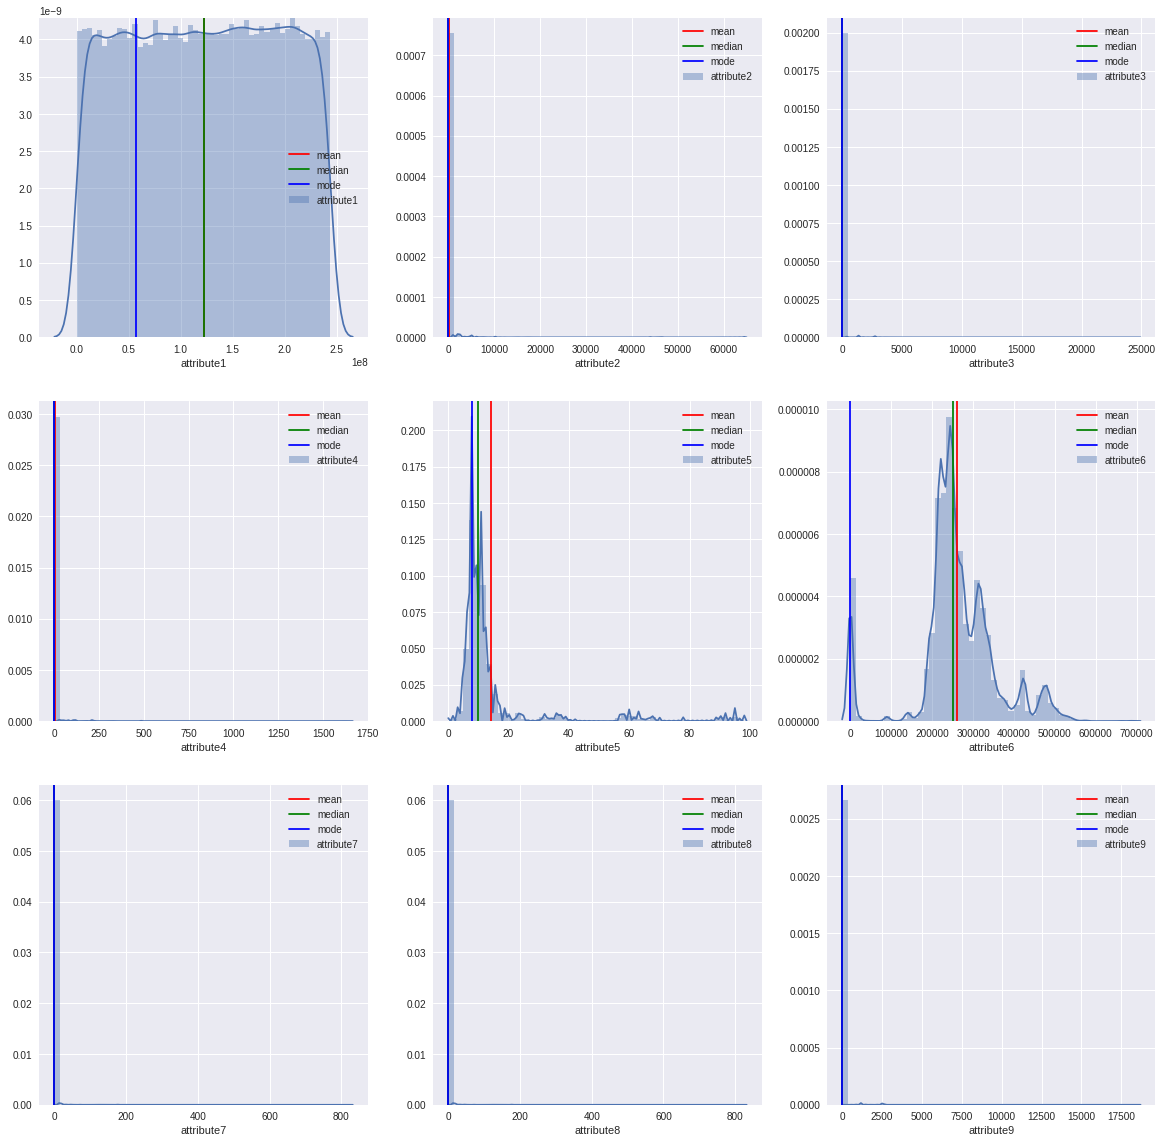

In [9]:
# Before log transform

EDA.plot_distribution(numeric_data)

In [10]:
logged_numeric_data = ETL.deskew_numeric_variables(numeric_data)
logged_numeric_data.head(2)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,19.189078,4.043051,0.000000,3.970292,1.94591,12.917647,0.0,0.0,2.079442
1,17.932443,0.000000,1.386294,0.000000,1.94591,12.907126,0.0,0.0,0.000000


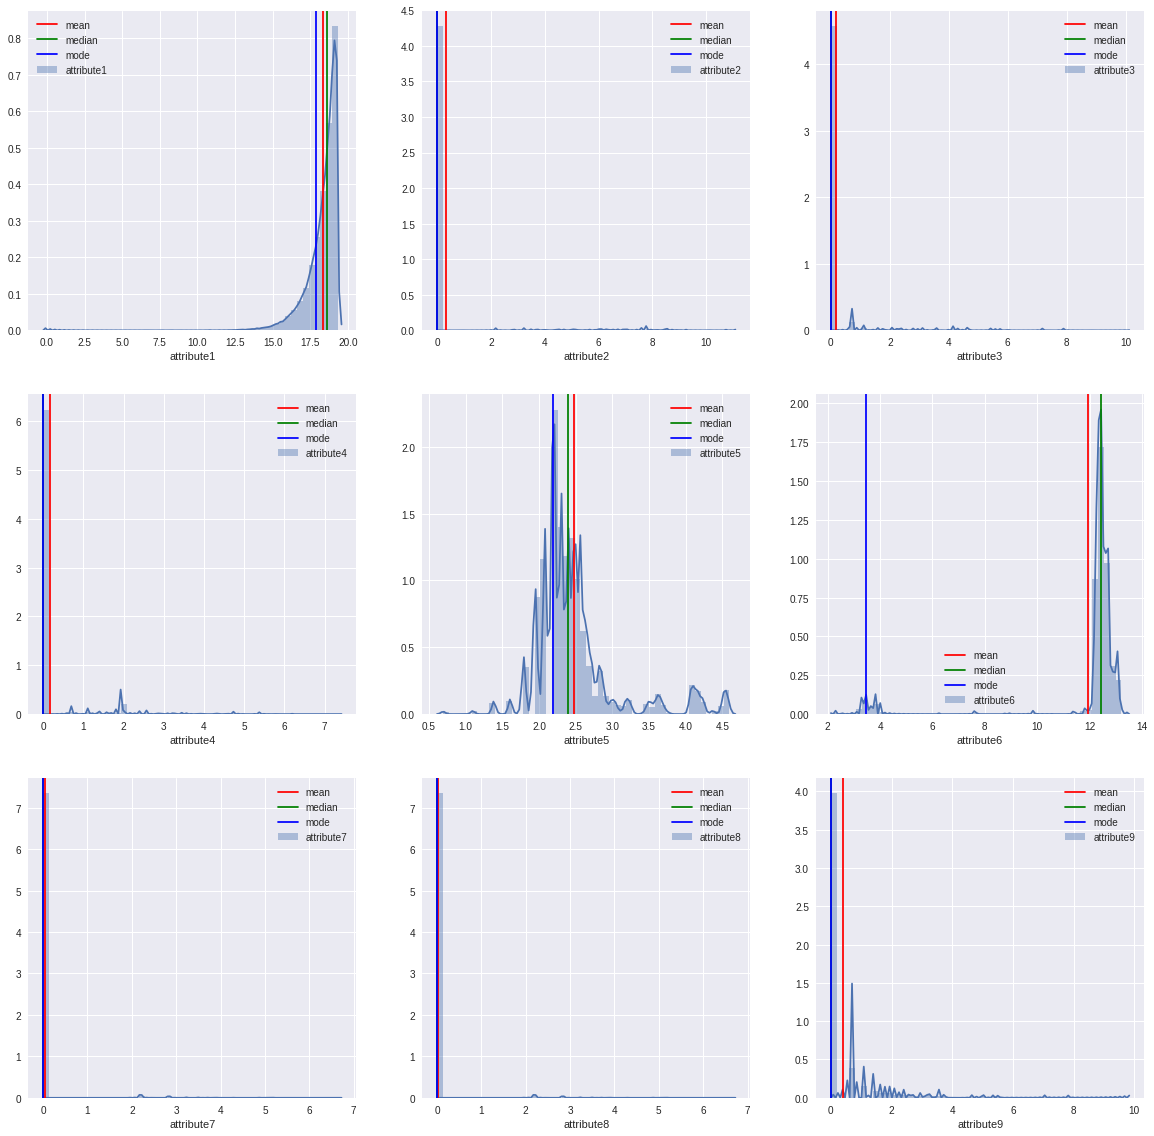

In [11]:
# After log transform

EDA.plot_distribution(logged_numeric_data)

In [12]:
# Compare skewness before and after log transform - almost all are closer to 0

EDA.compare_skew(numeric_data, logged_numeric_data)

,feature,original,logged
0,attribute1,-0.011143,-2.456721
1,attribute2,23.857636,4.704000
2,attribute3,82.711281,5.855294
3,attribute4,41.502111,4.790418
4,attribute5,3.483637,1.785854
5,attribute6,-0.375280,-3.565162
6,attribute7,73.475571,10.528286
7,attribute8,73.475571,10.528286
8,attribute9,49.898677,3.633828


In [13]:
# Pick and choose (exclude left-skewed)

numeric_data = pd.concat([numeric_data[['attribute1','attribute6']],logged_numeric_data[['attribute2','attribute3','attribute4','attribute5','attribute7','attribute8','attribute9']]], axis=1)
numeric_data.head(2)

,attribute1,attribute6,attribute2,attribute3,attribute4,attribute5,attribute7,attribute8,attribute9
0,215630672,407438,4.043051,0.000000,3.970292,1.94591,0.0,0.0,2.079442
1,61370680,403174,0.000000,1.386294,0.000000,1.94591,0.0,0.0,0.000000


### Encode categorical variables
Then merge transformed numeric and categorical features together.

In [14]:
categorical_data = ETL.encode_categorical_variables(data[cat_list])

original size:  (124494, 2)
new size:  (124494, 18)


In [15]:
transformed_data = ETL.merge_all_variables(numeric_data, categorical_data, data[misc_list])
transformed_data.head(2)

numeric variables:  (124494, 9)
cat_variables:  (124494, 18)
misc_variables:  (124494, 1)


,attribute1,attribute6,attribute2,attribute3,attribute4,attribute5,attribute7,attribute8,attribute9,dayofweek_0,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,failure
0,215630672,407438,4.043051,0.000000,3.970292,1.94591,0.0,0.0,2.079442,0,...,0,0,0,0,0,0,0,0,0,0
1,61370680,403174,0.000000,1.386294,0.000000,1.94591,0.0,0.0,0.000000,0,...,0,0,0,0,0,0,0,0,0,0


# 2. Exploratory Data Analysis (EDA)

In [16]:
features, target = ETL.extract_features_and_target(transformed_data)

### Explore `['month']`

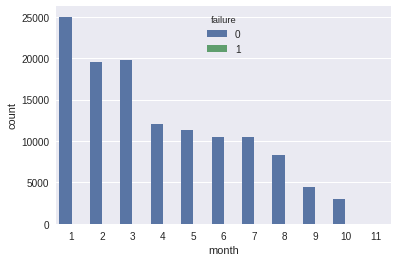

In [40]:
sns.countplot(x='month', hue='failure', data=data)

(0, 50)

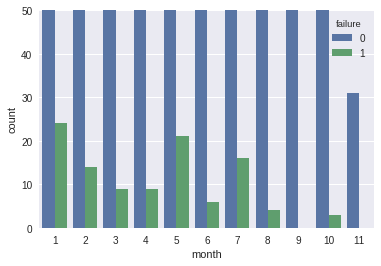

In [71]:
sns.countplot(x='month', hue='failure', data=data)
plt.ylim(0,50)

In [21]:
# Just looking at count can be misleading, use crosstab

pd.crosstab(data['month'], data['failure'], normalize='index')

failure,0,1
month,,
1,0.999041,0.000959
2,0.999282,0.000718
3,0.999546,0.000454
4,0.999251,0.000749
5,0.998147,0.001853
6,0.999427,0.000573
7,0.998481,0.001519
8,0.999521,0.000479
9,1.000000,0.000000


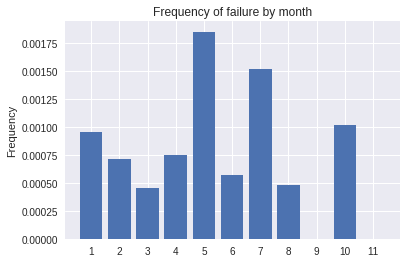

In [69]:
eda = pd.crosstab(data['month'], data['failure'], normalize='index').reset_index()

y_pos = np.arange(len(eda['month'].unique()))
plt.bar(y_pos, eda[1])
plt.xticks(y_pos, eda['month'].unique())
plt.ylabel('Frequency')
plt.title('Frequency of failure by month')
plt.show()

### Explore `['dayofweek']`

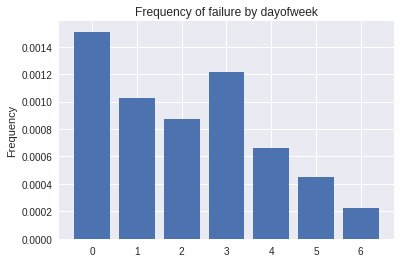

In [70]:
eda = pd.crosstab(data['dayofweek'], data['failure'], normalize='index').reset_index()

y_pos = np.arange(len(eda['dayofweek'].unique()))
plt.bar(y_pos, eda[1])
plt.xticks(y_pos, eda['dayofweek'].unique())
plt.ylabel('Frequency')
plt.title('Frequency of failure by dayofweek')
plt.show()

### Explore `['device']`

In [19]:
# Summarize failure by device

by_device = pd.crosstab(data['device'], data['failure'], normalize='index')
by_device.head(10)

failure,0,1
device,,
S1F01085,1.000000,0.000000
S1F013BB,1.000000,0.000000
S1F0166B,1.000000,0.000000
S1F01E6Y,1.000000,0.000000
S1F01JE0,1.000000,0.000000
S1F01R2B,1.000000,0.000000
S1F01TD5,1.000000,0.000000
S1F01XDJ,1.000000,0.000000
S1F023H2,0.947368,0.052632


In [20]:
# Summarize failure by device - sort by top 10

by_device.rename(columns={0:'N', 1:'Y'}, inplace=True)
by_device = by_device.sort_values(by='Y', ascending=False)
by_device.reset_index(inplace=True)
top_10 = by_device.head(10)
top_10

failure,device,N,Y
0,S1F0RRB1,0.800000,0.200000
1,S1F10E6M,0.857143,0.142857
2,S1F11MB0,0.857143,0.142857
3,S1F0CTDN,0.857143,0.142857
4,Z1F1AG5N,0.888889,0.111111
5,W1F0PNA5,0.888889,0.111111
6,W1F13SRV,0.923077,0.076923
7,W1F03DP4,0.928571,0.071429
8,W1F1230J,0.928571,0.071429
9,W1F0T034,0.941176,0.058824


(0, 5)

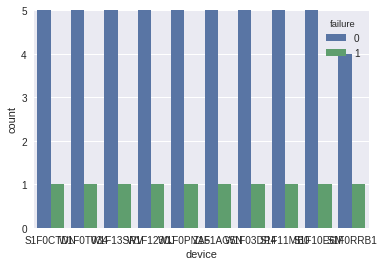

In [21]:
# Graph the top 10 devices with the most failure

top_10 = data[data['device'].isin(top_10['device'].unique())]
top_10_new = top_10.sort_values(by='failure')
sns.countplot(x='device', hue='failure', data=top_10_new)
plt.ylim(0,5)

At first glance, it seems like some devices fail more often than others, but a deeper look shows that the top 10 devices only have **one** count, so they are just the "top 10" because of its proportion to non-fail logs. Thus, we can conclude that `device` is not an important variable and can be dropped (it's also not worth it to keep it and one-hot-encode it). This also means we don't have to consider creating a feature for `['days_since_last_failure']`, since all the devices only fail once in our dataset.

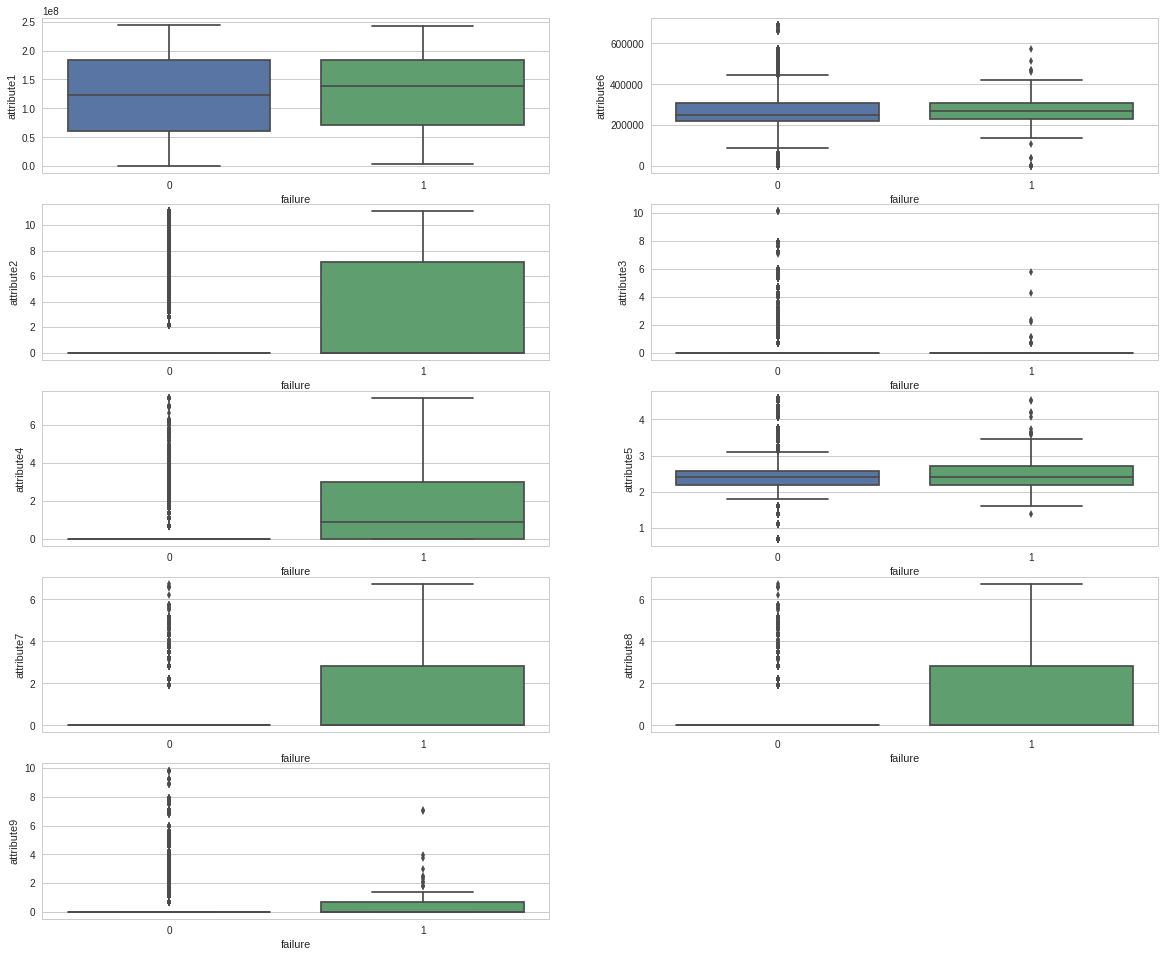

In [117]:
# The ones with the greatest discrepancy in distribution signal 
# their importance for failure prediction

EDA.plot_boxplots(transformed_data.iloc[:,:-19])

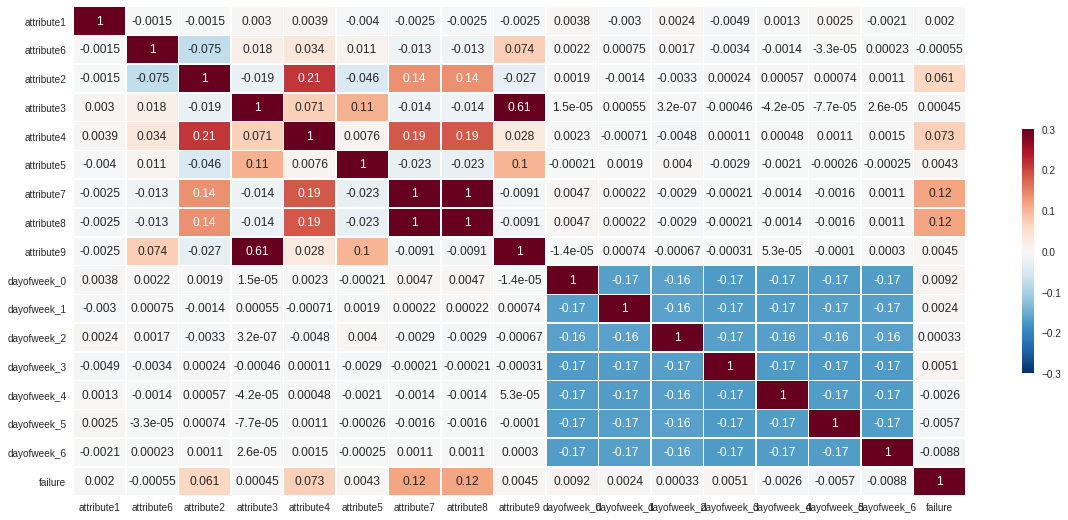

In [24]:
# Attributes 2,4,7 & 8 are slightly correlated with failure

EDA.plot_correltion_matrix(transformed_data)

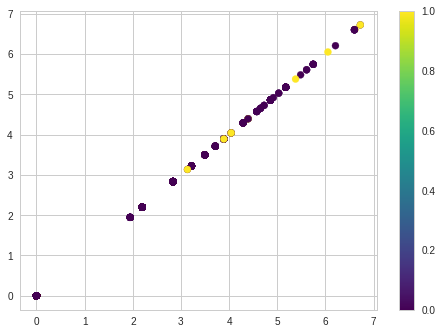

In [25]:
# attribute 7 & 8 are highly correlated, let's take a look

plt.scatter(transformed_data['attribute7'], transformed_data['attribute8'], c=target, cmap='RdBu')
plt.colorbar()

### Use Select K Best to find important features

In [118]:
# Instantiate a SelectKBest object with scoring funcion and how many columns you want to select
skb = SelectKBest(score_func=f_regression, k=5) #this narrows down our features space

skb.fit(features, target)

# To observe scores, zip column names and scores, then sort them in descending order.
feat_list = list(zip(features.columns,skb.scores_, skb.pvalues_))
feat_list.sort(key=lambda x: x[2], reverse=False)
pd.DataFrame(feat_list, columns=['feature','f-score','p-value'])

#look at the f-score, seems like we can take the top four features.

,feature,f-score,p-value
0,attribute7,1745.630794,0.000000e+00
1,attribute8,1745.630794,0.000000e+00
2,attribute4,658.414298,7.890052e-145
3,attribute2,467.364828,1.862268e-103
4,month_5,14.712846,1.252521e-04
5,dayofweek_0,10.634488,1.110278e-03
6,dayofweek_6,9.650078,1.893861e-03
7,month_7,6.032176,1.404876e-02
8,month_3,4.385218,3.625388e-02
9,dayofweek_5,4.019026,4.499186e-02


In [121]:
# Only keep significant attributes

selected_features = features[['attribute8', 'attribute4', 'attribute2']]

### Principal Component Analysis (PCA)
Use the first two principal components to visualize the data.

# of components needed to account for 90% variance:  20


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

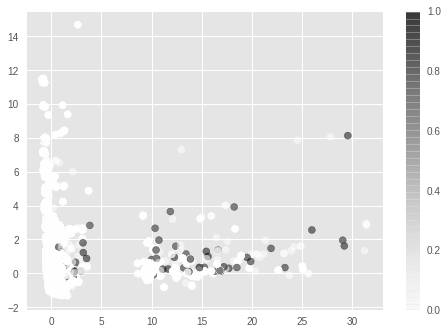

In [120]:
EDA.plot_pca(features, target)

# of components needed to account for 90% variance:  2


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

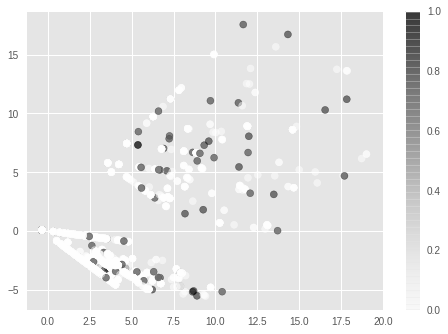

In [122]:
EDA.plot_pca(selected_features, target)

# 3. Train-test-split & resampling

### Generate training and test data

In [125]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3, random_state=33)

In [124]:
# Check if we're dealing with imbalanced classes

target.value_counts()

0    124388
1       106
Name: failure, dtype: int64

Our classes are super imbalanced. So even if our model predicts there are no alerts 100% of the time, we'd get a 99% accurary score. That's not effective. We must deal with imbalanced classes before modeling.

### Handle imbalanced classes
SMOTE synthesizes new minority classes by ignoring majority class examples, then for every minority instance it chooses its k-nearest-neighbors and if, for example, you want 300% replication, then 3 neighbors are chosen and it creates new instances halfway between the first instance and its neighbors.

In [126]:
sm = SMOTE(random_state=33, ratio = 1.0)
X_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train)

In [127]:
# Our data doubled in size

print(X_train.shape)
print(X_train_resampled.shape)

(87145, 27)
(174140, 27)


In [228]:
# Check classes are balanced

pd.Series(y_train_resampled).value_counts()

1    87070
0    87070
dtype: int64

# 4. Transformation & modeling pipelines

## Logistic Regression

In [36]:
LogisticRegression.get_params(LogisticRegression).keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [128]:
pipe = Pipeline([
    ('skb', SelectKBest(score_func=f_regression)),
    ('scaler', StandardScaler()),
    ('lg', LogisticRegression())
])

params = [
    {'skb__k': [8,9,10,11,12],
     'lg__penalty': ['l1','l2'],
     'lg__C': [0.01,0.5,1,1.5]
    }
]

In [136]:
lg_model = Modeling(pipe, params)
lg_model.fit_model()
lg_model.evaluate_model()

Time:  0:05:58.700206
Accuracy:  0.932474765054
F1:  0.0171473109899


,0,1
0,34805,2513
1,9,22


In [137]:
lg_model.best_estimator

Pipeline(memory=None,
     steps=[('skb', SelectKBest(k=10, score_func=<function f_regression at 0x7fea4eb46158>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('lg', Logi...penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

## Decision Tree

In [138]:
pipe = Pipeline([
    ('skb', SelectKBest(score_func=f_regression)),
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('dt', DecisionTreeClassifier())
])

params = [
    {'skb__k': [2,3],
     'dt__min_samples_leaf': [1,2]
    }
]

In [139]:
dt_model = Modeling(pipe, params)
dt_model.fit_model()
dt_model.evaluate_model()

Time:  0:00:07.870256
Accuracy:  0.998982569814
F1:  0.208333333333


,0,1
0,37306,12
1,26,5


In [140]:
dt_model.best_estimator

Pipeline(memory=None,
     steps=[('skb', SelectKBest(k=3, score_func=<function f_regression at 0x7fea4eb46158>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('dt', Decis...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

## Random Forest

In [141]:
pipe = Pipeline([
    ('skb', SelectKBest(score_func=f_regression)),
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('rf', RandomForestClassifier())
])

params = [
    {'skb__k': [9,12,15,16],
     'rf__min_samples_leaf': [1,2,3,4,5],
    'pca__n_components': [1,5,9]
    }
]

In [142]:
rf_model = Modeling(pipe, params)
rf_model.fit_model()
rf_model.evaluate_model()

Time:  0:20:24.730427
Accuracy:  0.997777718279
F1:  0.10752688172


,0,1
0,37261,57
1,26,5


In [143]:
rf_model.best_estimator

Pipeline(memory=None,
     steps=[('skb', SelectKBest(k=15, score_func=<function f_regression at 0x7fea4eb46158>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('rf', RandomF...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

## K-Nearest Neighbor

In [164]:
pipe = Pipeline([
    ('skb', SelectKBest(score_func=f_regression)),
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

params = [
    {'skb__k': [9,12,15,16],
     'knn__n_neighbors': [3],
    'pca__n_components': [1,5,9]
    }
]

In [165]:
knn_model = Modeling(pipe, params)
knn_model.fit_model()
knn_model.evaluate_model()

Time:  0:12:43.792535
Accuracy:  0.997991914107
F1:  0.157303370787


,0,1
0,37267,51
1,24,7


In [166]:
knn_model.best_estimator

Pipeline(memory=None,
     steps=[('skb', SelectKBest(k=15, score_func=<function f_regression at 0x7fea4eb46158>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform'))])

## XGBoost

In [196]:
pipe = Pipeline([
#     ('skb', SelectKBest(score_func=f_regression)),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier())
])

params = [{
#     {'skb__k': [16],
     'xgb__min_samples_leaf': [5,50,500],
     'xgb__learning_rate': [0.05, 0.1],
     'xgb__min_samples_split': [9,900],
     'xgb__min_samples_leaf': [5,50],
     'xgb__max_depth': [3,8],
     'xgb__max_features': ['sqrt']
    }
]

In [197]:
xgb_model = Modeling(pipe, params)
xgb_model.fit_model()
xgb_model.evaluate_model()

Time:  0:48:08.633421
Accuracy:  0.999036118772
F1:  0.1


,0,1
0,37311,7
1,29,2


In [202]:
xgb_model.best_estimator.named_steps['xgb']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, max_features='sqrt', min_child_weight=1,
       min_samples_leaf=5, min_samples_split=9, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

## Our best model was the Decision Tree with F1 score of 0.208